In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans


In [10]:
# =========================
# 1️⃣ Charger le dataset
# =========================
df = pd.read_csv(r"C:\Users\Ph\Downloads\dataset_entretien_ml_regression.csv")


In [11]:
# =========================
# 2️⃣ Nettoyage
# =========================
print("Doublons avant :", df.duplicated().sum())
df = df.drop_duplicates()
print("Doublons après :", df.duplicated().sum())

numeric_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(include='object').columns

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Valeurs manquantes :")
print(df.isnull().sum())

Doublons avant : 20
Doublons après : 0
Valeurs manquantes :
age                  0
revenu_mensuel       0
anciennete_annees    0
type_contrat         0
secteur              0
region               0
depense_annuelle     0
dtype: int64


              age  revenu_mensuel  anciennete_annees  depense_annuelle
count  300.000000      300.000000         300.000000      3.000000e+02
mean    41.018116   249811.793478           8.983333      1.515202e+06
std     12.932150    83000.817663           5.671886      5.339963e+05
min     18.000000   -19128.000000           0.000000      1.144190e+05
25%     31.000000   195212.500000           4.000000      1.177180e+06
50%     41.018116   249811.793478           9.000000      1.473730e+06
75%     52.000000   309222.000000          14.000000      1.818623e+06
max     64.000000   504963.000000          19.000000      3.005915e+06


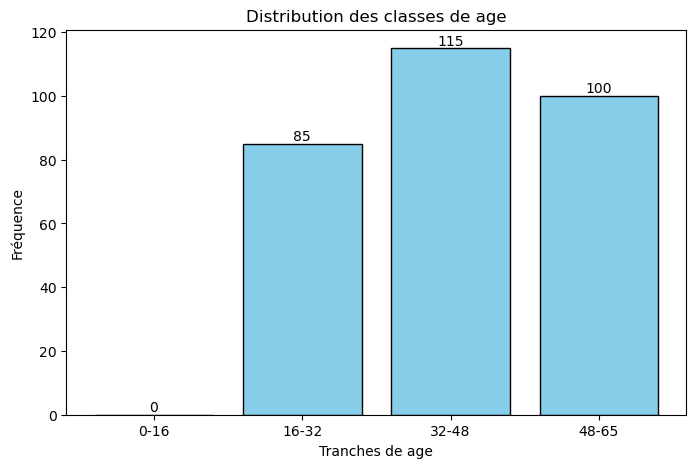

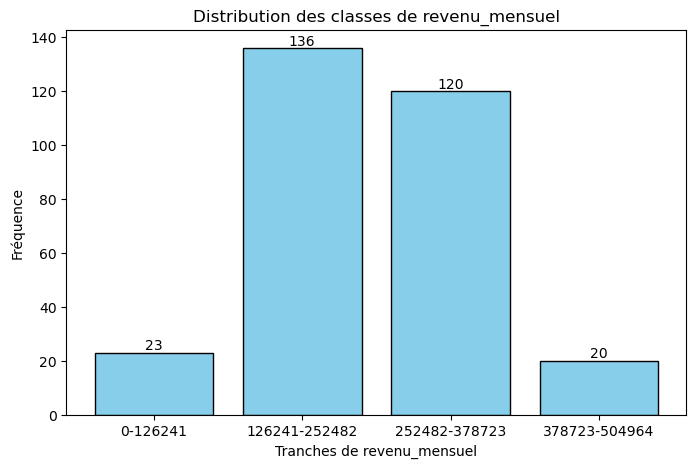

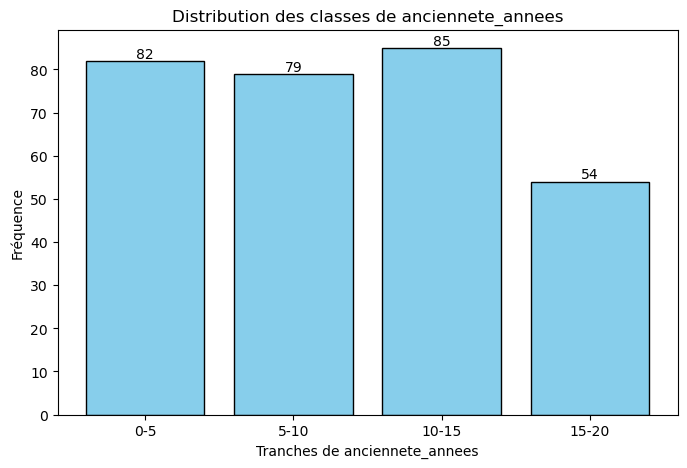

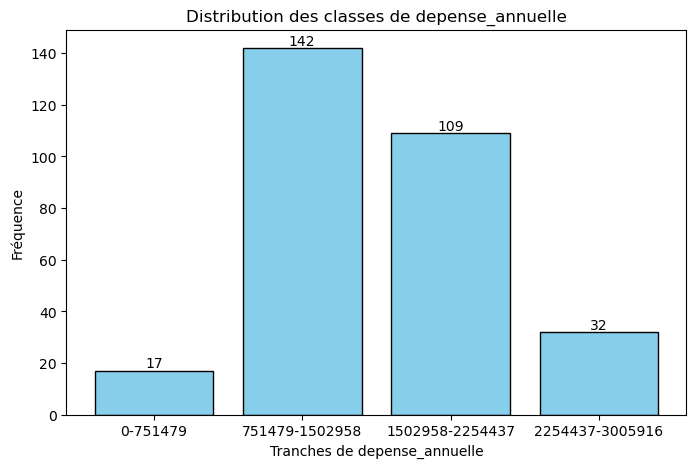

In [12]:
# =========================
# 3️⃣ Exploration rapide
# =========================
print(df.describe())

# Boucle sur toutes les colonnes numériques
for col in numeric_cols:
    # Création automatique des bins (4 classes) de 0 à max arrondi au multiple de 10 ou 20
    max_val = df[col].max()
    bins = np.linspace(0, max_val + 1, 5)  # 4 classes
    labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
    
    # Création de la colonne des classes
    df[f'{col}_group'] = pd.cut(df[col], bins=bins, labels=labels, right=False)
    
    # Comptage des fréquences
    counts = df[f'{col}_group'].value_counts().sort_index()
    
    # Histogramme avec étiquettes
    plt.figure(figsize=(8,5))
    bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
    
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()),
                 ha='center', va='bottom')
    
    plt.title(f"Distribution des classes de {col}")
    plt.xlabel(f"Tranches de {col}")
    plt.ylabel("Fréquence")
    plt.show()


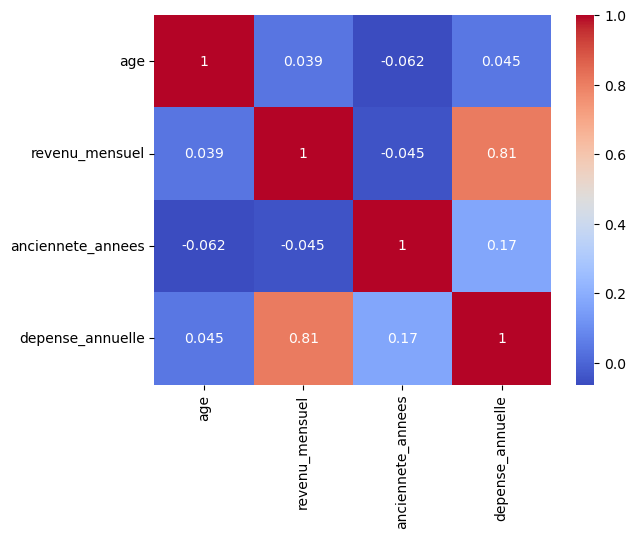

In [13]:
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

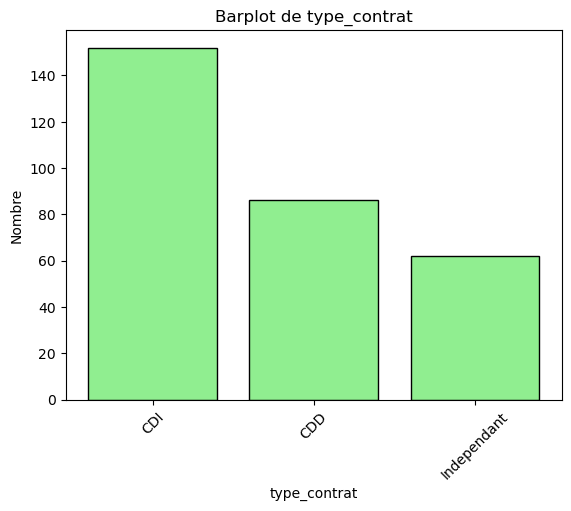

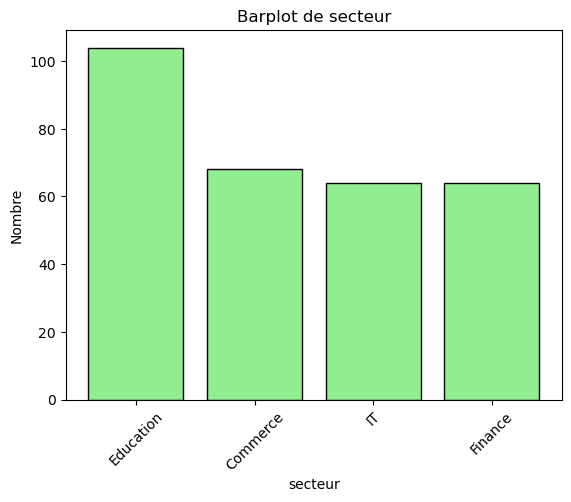

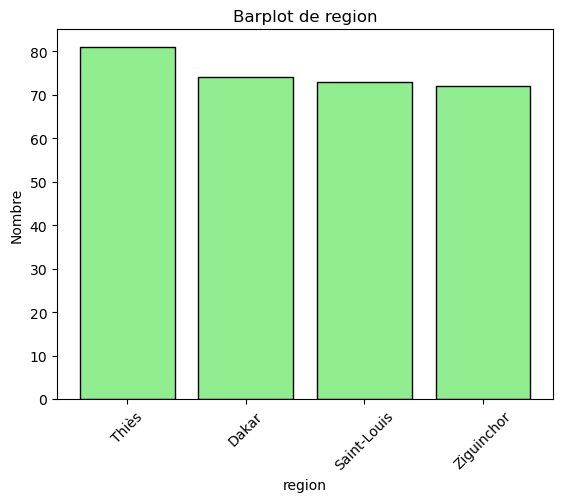

In [14]:
for col in cat_cols:
    counts = df[col].value_counts()
    plt.bar(counts.index, counts.values, color='lightgreen', edgecolor='black')
    plt.title(f"Barplot de {col}")
    plt.xlabel(col)
    plt.ylabel("Nombre")
    plt.xticks(rotation=45)
    plt.show()

In [15]:
# =========================
# 4️⃣ Préparation des données pour le clustering
# (pas de variable cible)
# =========================
X = df.copy()

numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(), categorical_features)
])

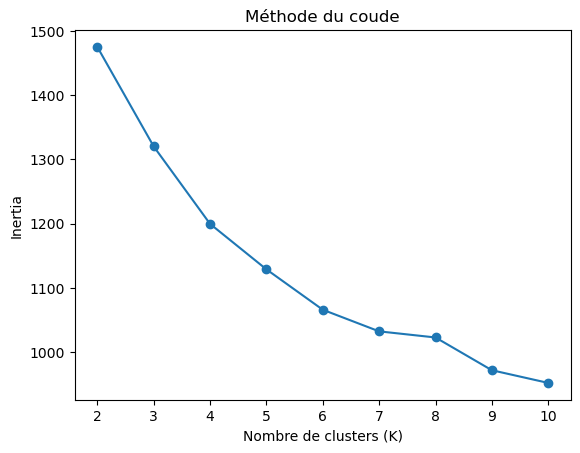

In [16]:
# =========================
# 5️⃣ Méthode du coude (choix de K)
# =========================
X_prepared = preprocessor.fit_transform(X)

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_prepared)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertia")
plt.title("Méthode du coude")
plt.show()


In [17]:
# =========================
# 6️⃣ Clustering avec K-Means
# =========================
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_prepared)

df['cluster'] = clusters

cluster
0    118
1    107
2     75
Name: count, dtype: int64
               age  revenu_mensuel  anciennete_annees  depense_annuelle
cluster                                                                
0        42.348839   178359.352155           6.847458      1.041527e+06
1        38.403562   271775.279460          14.551402      1.748434e+06
2        42.654541   330895.727826           4.400000      1.927705e+06


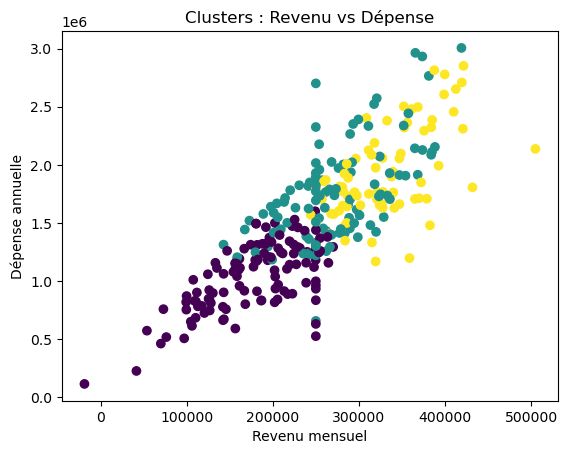

In [18]:
# =========================
# 7️⃣ Analyse des clusters
# =========================
print(df['cluster'].value_counts())

cluster_summary = df.groupby('cluster')[numeric_features].mean()
print(cluster_summary)

# Visualisation simple
plt.scatter(df['revenu_mensuel'], df['depense_annuelle'], c=df['cluster'])
plt.xlabel("Revenu mensuel")
plt.ylabel("Dépense annuelle")
plt.title("Clusters : Revenu vs Dépense")
plt.show()